In [292]:
import pandas as pd
import numpy as np
import time
import datetime
import pickle
import requests
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from math import floor, sin, cos, sqrt, atan2, radians, asin
import re
#from keras.layers import Dense, Dropout, Flatten
#from keras.layers.convolutional import Conv1D, MaxPooling1D
#from keras.models import Sequential
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler
import folium
import geopandas as gpd
from itertools import combinations
import osmium
import branca

pd.set_option('display.max_rows', 100)
sns.set_theme(style="whitegrid")
fig_dim = (16,9)

base = 'Data'
police_complaints_dataset="police_complaints"
#base = '/home/bsilva/Desktop'
#base = r'C:\Users\Carolina Alves\OneDrive - Universidade de Aveiro\WDL competition\Stage 3/'

In [7]:
# Opening and saving the original dataset
# We converted the file from csv to binary in order to read it faster
# You do not need to run this cell
def saving_dfs_as_binary_files(base, year_start, year_end):
    
    df = pd.read_csv(base+'/'+"san_salvario_" + str(year_start) + ".csv", sep=";")
    
    for year in range(year_start+1, year_end+1):
        _df_year = pd.read_csv(base+'/'+"san_salvario_" + str(year) + ".csv", sep=";")
        df = pd.concat([df, _df_year])
    
    pickle.dump(df, open(base+'/'+"df_raw", "wb"))
        
saving_dfs_as_binary_files(base+"/noise_data/csv_format", 2016, 2019)


#secalhar eliminar...
def saving_dfs_as_binary_files(base, file_list, raw_name):
    
    df = pd.read_csv(base+'/'+file_list[0]+ ".csv", sep=";")
    
    for file in file_list[1:]:
        _df_file = pd.read_csv(base+'/'+file+ ".csv", sep=";")
        df = pd.concat([df, _df_file])
    
    pickle.dump(df, open(base+'/'+raw_name, "wb"))
        


In [10]:

# Opening data
def get_sensors_data():
    df = pickle.load(open(base+'/'+"noise_data/csv_format/df_raw", "rb" ))

    for col in ['C1', 'C2', 'C3', 'C4', 'C5']:
        df[col] = df[col].str.replace(',', '.').astype(float)

    df['date'] = pd.to_datetime(df["Data"], format='%d-%m-%Y')
    df['year'] = df["date"].dt.year
    df['month'] = df["date"].dt.month
    df['day'] = df["date"].dt.day
    df['hour'] = df['Ora'].str.replace(':00', '').astype(int)


    return df[['date', 'year', 'month', 'day', 'hour', 'C1', 'C2', 'C3', 'C4', 'C5']]
    
df = get_sensors_data()
df

,date,year,month,day,hour,C1,C2,C3,C4,C5
0,2016-06-01,2016,6,1,0,61.1,58.8,63.7,60.4,60.2
1,2016-06-01,2016,6,1,1,57.2,56.1,60.4,57.7,58.4
2,2016-06-01,2016,6,1,2,52.5,53.4,52.9,56.7,56.5
3,2016-06-01,2016,6,1,3,50.6,46.6,45.7,47.9,55.6
4,2016-06-01,2016,6,1,4,47.4,46.2,45.1,45.8,56.8
...,...,...,...,...,...,...,...,...,...,...
8755,2019-12-31,2019,12,31,19,62.2,59.8,60.3,NaN,NaN
8756,2019-12-31,2019,12,31,20,59.4,59.7,55.9,NaN,NaN
8757,2019-12-31,2019,12,31,21,59.2,61.0,56.0,NaN,NaN
8758,2019-12-31,2019,12,31,22,57.0,60.2,56.0,NaN,NaN


### Complaints

In [82]:
gdf_zones = gpd.read_file(base+"/circoscrizioni_geo.zip")
gdf_zones.set_crs(epsg=3003, inplace=True) #original coordinate system
gdf_zones.to_crs(epsg=4326, inplace=True) #convert to the "traditional" coordinate system
gdf_zones

,NCIRCO,DENOM,geometry
0,1,Centro - Crocetta,"POLYGON ((7.65385 45.04991, 7.65489 45.05139, ..."
1,2,Santa Rita - Mirafiori,"POLYGON ((7.57787 45.04181, 7.58035 45.04427, ..."
2,3,San Paolo - Cenisia - Pozzo Strada - Cit Turin...,"POLYGON ((7.60367 45.07135, 7.60431 45.07222, ..."
3,5,Borgo Vittoria - Madonna di Campagna - Lucento...,"POLYGON ((7.61182 45.10712, 7.61264 45.10741, ..."
4,6,Barriera di Milano - Regio Parco - Barca - Ber...,"MULTIPOLYGON (((7.74046 45.11945, 7.74152 45.1..."
5,7,"Aurora, Vanchiglia - Sassi - Madonna del Pilone","POLYGON ((7.67136 45.08077, 7.67206 45.08175, ..."
6,8,San Salvario - Cavoretto - Borgo Po - Nizza Mi...,"POLYGON ((7.63602 45.02339, 7.63622 45.02355, ..."
7,4,San Donato - Campidoglio - Parella,"POLYGON ((7.60571 45.07408, 7.60575 45.07413, ..."


In [195]:
def append_to_df(df, path, xlsx=False, sep=','):
    df=pd.concat([
        df, 
        pd.read_excel(path, engine='openpyxl') if xlsx else pd.read_csv(path, sep=sep, encoding='latin-1')
    ])
    
    return df
 
def read_complaints():
    df_complaints=pd.read_csv('./Data/police_complaints/OpenDataContact_Gennaio_Giugno_2016.csv', sep=',')
    df_complaints=append_to_df(df_complaints, './Data/police_complaints/OpenDataContact_Gennaio_Giugno_2016.csv')
    df_complaints=append_to_df(df_complaints, './Data/police_complaints/Contact_Gennaio_Giugno_2017.csv')
    df_complaints=append_to_df(df_complaints, './Data/police_complaints/OpenDataContact_Luglio_Dicembre_2017.csv')
    df_complaints=append_to_df(df_complaints, './Data/police_complaints/OpenDataContact_Luglio_Dicembre_2018.csv')
    df_complaints=append_to_df(df_complaints, './Data/police_complaints/OpenDataContact_Gennaio_Giugno_2018.xlsx', xlsx=True)
    df_complaints=append_to_df(df_complaints, './Data/police_complaints/OpenDataContact_Gennaio_Giugno_2019.csv')
    df_complaints=append_to_df(df_complaints, './Data/police_complaints/OpenDataContact_Luglio_Dicembre_2019.csv', sep=';')
 
    return df_complaints
 
df_complaints=read_complaints()
df_complaints

,Categoria criminologa,Sottocategoria Criminologica,Circoscrizione,Localita,Area Verde,Data,Ora
0,Allarme Sociale,Altro,6.0,AEROPORTO/(STRADA DELL') ...,NaN,02/01/2016,NaN
1,Allarme Sociale,Altro,8.0,MADAMA CRISTINA/(PIAZZA) ...,NaN,13/01/2016,NaN
2,Allarme Sociale,Altro,2.0,RENI/GUIDO (VIA) ...,NaN,15/01/2016,NaN
3,Allarme Sociale,Altro,2.0,TRIPOLI/(VIA) ...,NaN,27/01/2016,NaN
4,Allarme Sociale,Altro,7.0,S. GIULIA/(PIAZZA) ...,NaN,03/02/2016,18.45
...,...,...,...,...,...,...,...
830,Qualità Urbana,Decoro e degrado urbano,4.0,AQUILA/(VIA) ...,NaN,26/12/2019,9.34
831,Qualità Urbana,Decoro e degrado urbano,5.0,VILLARI/PASQUALE (PIAZZA) ...,NaN,29/12/2019,9.08
832,Qualità Urbana,Decoro e degrado urbano,9.0,GALIMBERTI/TANCREDI (PIAZZA) ...,NaN,30/12/2019,12.57
833,Qualità Urbana,Decoro e degrado urbano,5.0,VERONESE/PAOLO (VIA) ...,NaN,31/12/2019,9.40


We will only keep complaints regarding district 8, San Salvario

In [196]:
df_complaints = df_complaints.loc[df_complaints['Sottocategoria Criminologica'] == 'Rumori molesti']


In [197]:
df_complaints['Sottocategoria Criminologica'].unique()

array(['Rumori molesti'], dtype=object)

Not all of the complaints are relevant to this challenge, such as complaints regarding abandoned vehicles, vandalism or aggressions. Therefore we are only interested in complaints regarding loud noises (Rumori molesti). Additionally, we will only keep complaints regarding district 8, San Salvario

In [205]:
df_complaints = df_complaints.loc[df_complaints['Sottocategoria Criminologica'] == 'Rumori molesti']
df_complaints = df_complaints.loc[df_complaints['Circoscrizione'] == 8.0]
df_complaints['Localita'] = df_complaints['Localita'].apply(lambda x : x.strip())
df_complaints.head()

,Categoria criminologa,Sottocategoria Criminologica,Circoscrizione,Localita,Area Verde,Data,Ora
557,Convivenza Civile,Rumori molesti,8.0,MARCONI/GUGLIELMO (CORSO),NaN,24/02/2016,NaN
562,Convivenza Civile,Rumori molesti,8.0,PETITTI/ILARIONE (VIA),NaN,10/03/2016,NaN
578,Convivenza Civile,Rumori molesti,8.0,GOITO/(VIA),NaN,15/04/2016,NaN
583,Convivenza Civile,Rumori molesti,8.0,GALLIARI/BERNARDINO (VIA),NaN,22/04/2016,NaN
592,Convivenza Civile,Rumori molesti,8.0,CELLINI/BENVENUTO (VIA),NaN,13/05/2016,NaN


<AxesSubplot:title={'center':'Locations with most noise complaints between 2016-2019 in San Salvario'}>

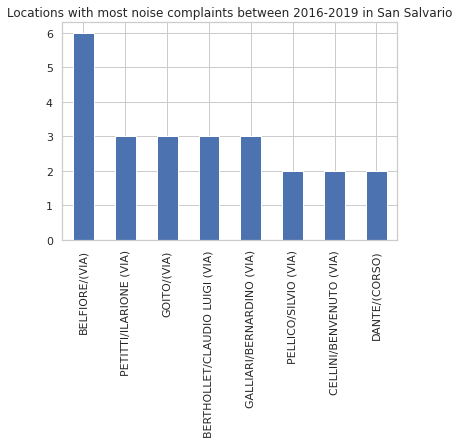

In [206]:
df_complaints['Localita'].value_counts()[:8].plot.bar(title="Locations with most noise complaints between 2016-2019 in San Salvario")

In [207]:
def convert_coord_to_number(coord_str):
    return float(coord_str.replace(',', '.'))

sensor_zones_df = pd.read_csv(base+"/noise_sensor_list.csv", sep=";")[['code', 'address', 'Lat', 'Long']]

sensor_zones_df['Lat'] = sensor_zones_df['Lat'].apply(lambda x : convert_coord_to_number(x))
sensor_zones_df['Long'] = sensor_zones_df['Long'].apply(lambda x : convert_coord_to_number(x))

sensor_zones_df

,code,address,Lat,Long
0,s_01,"Via Saluzzo, 26 Torino",45.059172,7.678986
1,s_02,"Via Principe Tommaso, 18bis Torino",45.057837,7.681555
2,s_03,Largo Saluzzo Torino,45.058518,7.678854
3,s_05,Via Principe Tommaso angolo via Baretti Torino,45.057603,7.681348
4,s_06,"Corso Marconi, 27 Torino",45.055554,7.682590


### Businesses and Noise Levels Analysis

Read file containing the businesses location and type and convert the coordinate system

In [208]:
gdf_businesses = gpd.read_file(base+"/businesses.csv", sep=';')
gdf_businesses.set_crs(epsg=3003, inplace=True) #original coordinate system
gdf_businesses.to_crs(epsg=4326, inplace=True) #convert to the "traditional" coordinate system

gdf_businesses.head(10)

,WKT,ADDRESS,OPEN YEAR,OPEN MONTH,TYPE,Description,Merchandise Type,geometry
0,POINT (1396322.217 4990301.69),VIA CLAUDIO LUIGI BERTHOLLET 24,1977,1,EXTRALIMENTARI,PICCOLE STRUTTURE,Extralimentari,POINT (7.68288 45.05840)
1,POINT (1396322.217 4990301.69),VIA CLAUDIO LUIGI BERTHOLLET 24,1985,6,ALIMENTARI,PICCOLE STRUTTURE,Panificio,POINT (7.68288 45.05840)
2,POINT (1396303.762 4990325.001),VIA CLAUDIO LUIGI BERTHOLLET 25/F,2017,9,ALTRO,DIA di somministrazione,Nessuna,POINT (7.68265 45.05861)
3,POINT (1396434.395 4990540.6),CORSO VITTORIO EMANUELE II 21/A,2013,10,ALTRO,DIA di somministrazione,Nessuna,POINT (7.68426 45.06057)
4,POINT (1396434.395 4990540.6),CORSO VITTORIO EMANUELE II 21/A,2009,2,ALTRO,DIA di somministrazione,Nessuna,POINT (7.68426 45.06057)
5,POINT (1396346.317 4990465.903),VIA PRINCIPE TOMMASO 3/G,2012,11,ALTRO,Somministrazione,Nessuna,POINT (7.68316 45.05988)
6,POINT (1396323.163 4990446.922),VIA PRINCIPE TOMMASO 6/E,2016,4,.,Somministrazione,Nessuna,POINT (7.68287 45.05971)
7,POINT (1396326.293 4990453.035),VIA PRINCIPE TOMMASO 6,1998,5,ALTRO,DIA di somministrazione,Nessuna,POINT (7.68290 45.05977)
8,POINT (1396009.149 4990467.107),VIA CLAUDIO LUIGI BERTHOLLET 2/G,2017,3,MISTA,PICCOLE STRUTTURE,Gastronomia,POINT (7.67887 45.05985)
9,POINT (1396357.532 4990581.082),CORSO VITTORIO EMANUELE II 25/G,2017,4,EXTRALIMENTARI,PICCOLE STRUTTURE,Mobili,POINT (7.68327 45.06092)


In [235]:
unique_adresses = gdf_businesses.ADDRESS.unique()
unique_adresses

array(['VIA CLAUDIO LUIGI BERTHOLLET 24',
       'VIA CLAUDIO LUIGI BERTHOLLET 25/F',
       'CORSO VITTORIO EMANUELE II 21/A', 'VIA PRINCIPE TOMMASO 3/G',
       'VIA PRINCIPE TOMMASO 6/E', 'VIA PRINCIPE TOMMASO 6',
       'VIA CLAUDIO LUIGI BERTHOLLET 2/G',
       'CORSO VITTORIO EMANUELE II 25/G', 'VIA PRINCIPE TOMMASO 9',
       'VIA PRINCIPE TOMMASO 11/B', 'VIA CLAUDIO LUIGI BERTHOLLET 3/G',
       'CORSO VITTORIO EMANUELE II 25',
       'VIA CLAUDIO LUIGI BERTHOLLET 4/C',
       'CORSO VITTORIO EMANUELE II 27/C',
       'VIA CLAUDIO LUIGI BERTHOLLET 4', 'VIA GOITO 15',
       'PIAZZETTA LEVI PRIMO 9/B', 'VIA SALUZZO 32', 'VIA GOITO 16',
       'VIA CLAUDIO LUIGI BERTHOLLET 4 bis/F', 'VIA SILVIO PELLICO 11/C',
       'CORSO VITTORIO EMANUELE II 27/F', 'VIA GOITO 17/B',
       'VIA SALUZZO 32 bis/A', 'VIA CLAUDIO LUIGI BERTHOLLET 5/A',
       'VIA SALUZZO 1/E', 'VIA SALUZZO 3',
       'CORSO VITTORIO EMANUELE II 29/B', 'VIA SALUZZO 40/B',
       'CORSO VITTORIO EMANUELE II 29/E', '

In [258]:
#df_complains_by_local = df_complaints.groupby(['Localita'])['Localita'].count().reset_index()
#df_complains_by_local = df_complaints({'count' : df_complaints.groupby(["Localita"]).size()}).reset_index()
df_complains_by_local = df_complaints.groupby("Localita").size().reset_index(name='complaint_count')
df_complains_by_local

,Localita,complaint_count
0,AMADEO/G. ANTONIO (VIA),1
1,ARGENTERO/GIOVANNI (VIA),1
2,ASTI/(VIA),1
3,BARETTI/GIUSEPPE (VIA),1
4,BELFIORE/(VIA),6
5,BERTHOLLET/CLAUDIO LUIGI (VIA),3
6,CANOVA/ANTONIO (VIA),1
7,CELLINI/BENVENUTO (VIA),2
8,D'AZEGLIO/MASSIMO (CORSO),1
9,DANTE/(CORSO),2


In [249]:
def search_address(address):
    key_words = re.split(r'\W+', address)
    if "VIA" in key_words:
        key_words.remove("VIA")
    if "CORSO" in key_words:
        key_words.remove("CORSO")
    ratio = 0
    matched_addr=""
    for adr in unique_adresses:
        adr_words = re.split(r'\W+', adr)
        r = 0
        for word in key_words:
            if word in adr_words:
                r +=1
        if r > ratio:
            matched_addr = adr
    return matched_addr

#search_address("BELFIORE/(VIA)") #Test

In [279]:
def add_coords(local):
    address = search_address(local)
    if address != "":
        #get coordinate of address
        c = gdf_businesses.loc[gdf_businesses['ADDRESS'] == address, 'geometry'].iloc[0]
        return (c.y, c.x)
    
df_complains_by_local['coords'] = df_complains_by_local.apply(lambda x: add_coords(x['Localita']), axis=1)
df_complains_by_local

,Localita,complaint_count,coords
0,AMADEO/G. ANTONIO (VIA),1,"(45.06039423746373, 7.679720707162653)"
1,ARGENTERO/GIOVANNI (VIA),1,None
2,ASTI/(VIA),1,None
3,BARETTI/GIUSEPPE (VIA),1,"(45.0575352701371, 7.681219625833094)"
4,BELFIORE/(VIA),6,"(45.05910054446746, 7.680404960837597)"
5,BERTHOLLET/CLAUDIO LUIGI (VIA),3,"(45.05841497812373, 7.68285015169853)"
6,CANOVA/ANTONIO (VIA),1,None
7,CELLINI/BENVENUTO (VIA),2,None
8,D'AZEGLIO/MASSIMO (CORSO),1,"(45.0603350987562, 7.682670947031643)"
9,DANTE/(CORSO),2,None


For this district, between 2016 and 2019, there was a minimum of 1 complain and a maximum of 6 complains

In [288]:
#assign colors to the number of complains
dic_category_colors = {
    1: 'blue',
    2: 'green',
    3: 'yellow',
    4: 'orange',
    5: 'red',
    6: 'darkred'
}

In [122]:
d = dict.fromkeys(gdf_businesses.Description.unique())
d

{'PICCOLE STRUTTURE': None,
 'DIA di somministrazione': None,
 'Somministrazione': None,
 'Acconciatori/estetisti': None,
 'MEDIE STRUTTURE': None,
 'FORME SPECIALI DI VENDITA': None,
 'Attivita didattiche': None,
 'COSE ANTICHE E USATE': None}

In [ ]:
d['PICCOLE STRUTTURE'] = 'SMALL STRUCTURES'
d['DIA di somministrazione'] = 'DIA of administration'
d['Somministrazione'] = 'Administration'
d['Acconciatori/estetisti'] = 'Hairdressers / beauticians'
d['MEDIE STRUTTURE'] = 'MEDIUM STRUCTURES'
d['FORME SPECIALI DI VENDITA'] = 'SPECIAL FORMS OF SALE'
d['Attivita didattiche'] = 'Educational activities'
d['COSE ANTICHE E USATE'] = 'ANCIENT AND USED THINGS'

In [ ]:
d['EXTRALIMENTARI'] = 'EXTRALIMENTARIES'
d['ALIMENTARI'] = 'FOOD'
d['ALTRO'] = 'OTHER'
d['.'] = '.'
d['MISTA'] = 'MIXED'

In [325]:
m=folium.Map(location=[45.05801, 7.68204], zoom_start=16)
def add_marker(title, descr, lat, long, group, color, icon):
    folium.Marker(location=[float(lat), float(long)], popup="<html>"+title+"<br/>"+descr+"</html>",
                 icon=folium.Icon(color=color, icon=icon)).add_to(group)
    
def add_circle_mark(title, descr, n, coords, group):
    if coords == None:
        return
    folium.Marker(location=[coords[0], coords[1]], popup="<html>"+title+"<br/>"+descr+"</html>",\
                icon=folium.Icon(color=dic_category_colors[n], icon='volume-up')).add_to(group)
    
comp_group = folium.FeatureGroup('Markers - complains')
comp_group.add_to(m)
bus_group = folium.FeatureGroup('Markers - businesses')
bus_group.add_to(m)
sens_group = folium.FeatureGroup('Markers - sensors')
sens_group.add_to(m)

    
gdf_businesses.apply(lambda l: add_marker("type: "+l['Merchandise Type'], "", l.geometry.y, l.geometry.x, 
                                          bus_group, 'white','usd'),axis=1)
sensor_zones_df.apply(lambda l: add_marker("sensor code: "+str(l['code']), l['address'], l.Lat, l.Long, 
                                           sens_group, 'black', 'hdd'),axis=1)

                                 
#add complaint data
df_complains_by_local.apply(lambda l: add_circle_mark("Address: "+str(l['Localita']), "Nº complains: "+
                           str(l['complaint_count']), l['complaint_count'], l.coords, comp_group),axis=1)

#adapted from: https://geopandas.readthedocs.io/en/latest/gallery/polygon_plotting_with_folium.html
for _, r in gdf_zones.iterrows():
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j, name=r['DENOM'],
                           style_function=lambda x: {'fillColor': 'orange'})
    folium.Popup("zone code: "+str(r['NCIRCO'])+"\ndistrict: "+r['DENOM']).add_to(geo_j)
    geo_j.add_to(m)

folium.LayerControl().add_to(m)
#add legend
legend_html = '''
{% macro html(this, kwargs) %}
<div style="
    position: fixed; 
    bottom: 140px;
    left: 20px;
    width: 120px;
    height: 80px;
    z-index:9999;
    font-size:14px;
    ">
    <p><a style="color:'''+str(dic_category_colors[1])+''';font-size:120%;margin-left:20px;">&#9679;</a>&emsp;'''+str(1)+'''</p>
    <p><a style="color:'''+str(dic_category_colors[2])+''';font-size:120%;margin-left:20px;">&#9679;</a>&emsp;'''+str(2)+'''</p>
    <p><a style="color:'''+str(dic_category_colors[3])+''';font-size:120%;margin-left:20px;">&#9679;</a>&emsp;'''+str(3)+'''</p>
    <p><a style="color:'''+str(dic_category_colors[4])+''';font-size:120%;margin-left:20px;">&#9679;</a>&emsp;'''+str(4)+'''</p>
    <p><a style="color:'''+str(dic_category_colors[5])+''';font-size:120%;margin-left:20px;">&#9679;</a>&emsp;'''+str(5)+'''</p>
    <p><a style="color:'''+str(dic_category_colors[6])+''';font-size:120%;margin-left:20px;">&#9679;</a>&emsp;'''+str(6)+'''</p>
</div>
<div style="
    position: fixed; 
    bottom: 20px;
    left: 20px;
    width: 70px;
    height: 200px; 
    z-index:9998;
    font-size:14px;
    background-color: #ffffff;
    opacity: 0.7;
    ">
</div>
{% endmacro %}
'''
legend = branca.element.MacroElement()
legend._template = branca.element.Template(legend_html)
m.get_root().add_child(legend)

m

<ipython-input-325-0a4adc2fad77>:10: UserWarning: color argument of Icon should be one of: {'orange', 'darkred', 'purple', 'beige', 'lightblue', 'darkpurple', 'red', 'lightgreen', 'lightgray', 'white', 'blue', 'pink', 'darkblue', 'gray', 'lightred', 'cadetblue', 'darkgreen', 'green', 'black'}.
  icon=folium.Icon(color=dic_category_colors[n], icon='volume-up')).add_to(group)


Todo: para cada complaint, nº de locais de lazer na rua. Mais locais de lazer mais queixas?

Queixas perto de um hotel?

In [77]:
gpd_census = gpd.read_file(base+"/census_data/sezioni_censimento_geo_CAP.shp")
gpd_census

,SEZCENS,NCIRCO,DENCIM,LOCALITA,DISTRASS,PARROCCH,TIPOSEZ,ASL,ZONASTAT,NRESID,NFAMIGL,NMASCHI,NFEMM,NSTRAN,AN_0_14,AN_15_64,OLT_65_A,SUPERF,geometry
0,326.0,8.0,Monumentale,TORINO,08A,Santi Pietro e Paolo Apostoli,0.0,ASL TO1,09,181.0,94.0,95.0,86.0,42.0,23.0,121.0,37.0,5593.24,"POLYGON ((1396082.920 4990558.645, 1396116.595..."
1,328.0,8.0,Monumentale,TORINO,08A,Santi Pietro e Paolo Apostoli,0.0,ASL TO1,09,252.0,144.0,123.0,129.0,110.0,29.0,167.0,56.0,8403.30,"POLYGON ((1396230.062 4990481.191, 1396261.287..."
2,336.0,8.0,Monumentale,TORINO,08A,Santi Pietro e Paolo Apostoli,0.0,ASL TO1,09,229.0,126.0,112.0,117.0,26.0,26.0,149.0,54.0,9976.84,"POLYGON ((1396319.969 4990427.448, 1396404.856..."
3,338.0,8.0,Monumentale,TORINO,08A,Santi Pietro e Paolo Apostoli,0.0,ASL TO1,09,294.0,160.0,141.0,153.0,27.0,45.0,192.0,57.0,15116.92,"POLYGON ((1396509.732 4990327.177, 1396638.065..."
4,343.0,8.0,Monumentale,TORINO,08A,Santi Pietro e Paolo Apostoli,0.0,ASL TO1,09,253.0,150.0,121.0,132.0,72.0,29.0,168.0,56.0,6922.80,"POLYGON ((1396272.570 4990334.580, 1396356.838..."
5,346.0,8.0,Monumentale,TORINO,08A,Santi Pietro e Paolo Apostoli,0.0,ASL TO1,09,172.0,86.0,90.0,82.0,21.0,18.0,123.0,31.0,4052.06,"POLYGON ((1396110.590 4990337.667, 1396159.829..."
6,356.0,8.0,Monumentale,TORINO,08A,Santi Pietro e Paolo Apostoli,0.0,ASL TO1,09,339.0,196.0,163.0,176.0,70.0,31.0,229.0,79.0,9174.29,"POLYGON ((1396289.940 4990160.821, 1396390.936..."
7,322.0,8.0,Monumentale,TORINO,08A,Santi Pietro e Paolo Apostoli,0.0,ASL TO1,09,113.0,65.0,55.0,58.0,15.0,15.0,77.0,21.0,9446.12,"POLYGON ((1396389.050 4990563.934, 1396399.090..."
8,323.0,8.0,Monumentale,TORINO,08A,Santi Pietro e Paolo Apostoli,0.0,ASL TO1,09,84.0,50.0,43.0,41.0,8.0,10.0,53.0,21.0,11706.68,"POLYGON ((1396486.289 4990539.884, 1396593.428..."
9,324.0,8.0,Monumentale,TORINO,08A,Santi Pietro e Paolo Apostoli,0.0,ASL TO1,09,177.0,107.0,82.0,95.0,15.0,13.0,91.0,73.0,14107.72,"POLYGON ((1396593.428 4990483.221, 1396714.465..."


<AxesSubplot:>

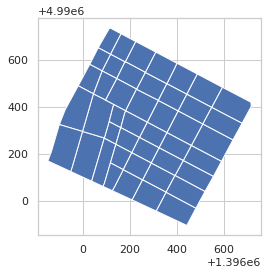

In [73]:
gpd_census.plot()

In [79]:

gpd_census = gpd.read_file(base+"/census_data/Torino_ACE81_3003.shp")
gpd_census

,COD_REG,COD_ISTAT,PRO_COM,SEZ2011,SEZ,COD_STAGNO,COD_FIUME,COD_LAGO,COD_LAGUNA,COD_VAL_P,...,COD_MONT_D,LOC2011,COD_LOC,TIPO_LOC,COM_ASC,COD_ASC,ACE,Shape_Leng,Shape_Area,geometry
0,1.0,1001272.0,1272.0,12720003790,3790.0,0.0,20019.0,0.0,0.0,0.0,...,0.0,127210001.0,10001.0,1.0,1272008.0,8,81,601.187894,17122.466063,"POLYGON ((1397684.098 4990958.745, 1397676.338..."
1,1.0,1001272.0,1272.0,12720000331,331.0,0.0,0.0,0.0,0.0,0.0,...,0.0,127210001.0,10001.0,1.0,1272008.0,8,81,451.345452,11664.272996,"POLYGON ((1396544.848 4990399.869, 1396674.057..."
2,1.0,1001272.0,1272.0,12720003788,3788.0,0.0,20019.0,0.0,0.0,0.0,...,0.0,127210001.0,10001.0,1.0,1272008.0,8,81,1192.624459,27377.568756,"POLYGON ((1397381.695 4990677.529, 1397368.147..."
3,1.0,1001272.0,1272.0,12720002472,2472.0,0.0,0.0,0.0,0.0,0.0,...,0.0,127210001.0,10001.0,1.0,1272008.0,8,81,2057.740794,43228.550156,"POLYGON ((1396824.866 4989610.669, 1396722.418..."
4,1.0,1001272.0,1272.0,12720000321,321.0,0.0,0.0,0.0,0.0,0.0,...,0.0,127210001.0,10001.0,1.0,1272008.0,8,81,400.517124,10047.172479,"POLYGON ((1396298.448 4990620.419, 1396306.367..."
5,1.0,1001272.0,1272.0,12720000350,350.0,0.0,0.0,0.0,0.0,0.0,...,0.0,127210001.0,10001.0,1.0,1272008.0,8,81,436.297481,10602.001633,"POLYGON ((1396423.431 4990173.513, 1396551.979..."
6,1.0,1001272.0,1272.0,12720000342,342.0,0.0,0.0,0.0,0.0,0.0,...,0.0,127210001.0,10001.0,1.0,1272008.0,8,81,340.698338,7098.189539,"POLYGON ((1396158.959 4990319.998, 1396173.950..."
7,1.0,1001272.0,1272.0,12720000324,324.0,0.0,0.0,0.0,0.0,0.0,...,0.0,127210001.0,10001.0,1.0,1272008.0,8,81,479.418676,14107.568787,"POLYGON ((1396590.755 4990485.467, 1396711.794..."
8,1.0,1001272.0,1272.0,12720000888,888.0,0.0,0.0,0.0,0.0,0.0,...,0.0,127210001.0,10001.0,1.0,1272008.0,8,81,356.414916,8250.132066,"POLYGON ((1396186.680 4989126.652, 1396223.415..."
9,1.0,1001272.0,1272.0,12720003230,3230.0,0.0,0.0,0.0,0.0,0.0,...,0.0,127210001.0,10001.0,1.0,1272008.0,8,81,310.518677,5262.393256,"POLYGON ((1396270.282 4988899.536, 1396299.801..."


<AxesSubplot:>

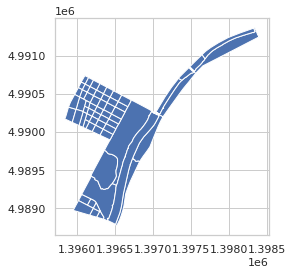

In [80]:
gpd_census.plot()